In [3]:
import torch
import numpy as np
import cupy as cp
import pyfftw
import matplotlib.pyplot as plt
import time


In [4]:
print('PyTorch: {}'.format(torch.__version__))
print('Numpy: {}'.format(np.__version__))
print('CuPy: {}'.format(cp.__version__))
print('pyFFTW: {}'.format(pyfftw.__version__))

PyTorch: 1.8.0.dev20201111+cu110
Numpy: 1.19.2
CuPy: 6.0.0
pyFFTW: 0.12.0


In [5]:
def torch_ifft_fft(data):
    signal_ndim = 2
    data2 = torch.fft(data, signal_ndim=signal_ndim)
    return torch.ifft(data2, signal_ndim=signal_ndim)

def np_ifft2_fft2(data):
    data2 = np.fft.fft2(data)
    return np.fft.ifft2(data2)

def cp_ifft2_fft2(data):
    data2 = cp.fft.fft2(data)
    return cp.fft.ifft2(data2)

def pyfftw_ifft2_fft2(data):
    data2 = pyfftw.interfaces.numpy_fft.fft2(data)
    return pyfftw.interfaces.numpy_fft.ifft2(data2)

In [6]:
names = []
totaltimes = []
sizes = [512, 1024, 2048, 4096] # X * X pixel arrays/tensors

PyTorch CPU

In [7]:
name = 'PyTorch\nCPU'
device_type = 'cpu'
device = torch.device(device_type)
names.append(name)
torchtimes = []
datas = [torch.randn((x,x,2), device=device) for x in sizes]
print(f'Working on device: {datas[0].device}')
for x, data in zip(sizes, datas):
    print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
    t = %timeit -o torch_ifft_fft(data)
    torchtimes.append(t)
totaltimes.append(torchtimes)

Working on device: cpu
PyTorch CPU 512x512


C:\Anaconda3\envs\astro\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The function torch.fft is deprecated and will be removed in PyTorch 1.8. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.fftn. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:651.)
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\envs\astro\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The function torch.ifft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.ifftn. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:662.)
  after removing the cwd from sys.path.


5.16 ms ± 330 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
PyTorch CPU 1024x1024
19 ms ± 489 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
PyTorch CPU 2048x2048
74.4 ms ± 977 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
PyTorch CPU 4096x4096
318 ms ± 6.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


PyTorch GPU

In [8]:
sizes = [512, 1024, 2048, 4096] # X * X pixel arrays/tensors
names = []
totaltimes = []
name = 'PyTorch\nGPU'
device_type = 'cuda'
device = torch.device('cuda:{}'.format(0))
names.append(name)
print('{} available: {}'.format(name, torch.cuda.is_available()))
torchtimes = []
datas = [torch.randn(size=(x,x,2), device=device) for x in sizes]
print(f'Working on device: {datas[0].device}')
for x, data in zip(sizes, datas):
    print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
    start = time.process_time()
    t = %timeit -o torch_ifft_fft(data)
    #torch_ifft_fft(data)
    #end = time.process_time()
    #t=end-start
    torchtimes.append(t)
totaltimes.append(torchtimes)

PyTorch
GPU available: True
Working on device: cuda:0
PyTorch GPU 512x512
187 µs ± 23.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
PyTorch GPU 1024x1024
855 µs ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
PyTorch GPU 2048x2048
3.99 ms ± 45.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
PyTorch GPU 4096x4096
The slowest run took 4.05 times longer than the fastest. This could mean that an intermediate result is being cached.
7.23 ms ± 5.17 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Numpy CPU

In [9]:
name = 'Numpy\nCPU'
names.append(name)
nptimes = []
datas = [np.random.normal(size=(x,x)).astype('complex128') for x in sizes]
for x, data in zip(sizes, datas):
    print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
    t = %timeit -o np_ifft2_fft2(data)
    nptimes.append(t)
totaltimes.append(nptimes)

Numpy CPU 512x512
45.1 ms ± 880 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Numpy CPU 1024x1024
235 ms ± 30 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numpy CPU 2048x2048
982 ms ± 61.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numpy CPU 4096x4096
4.39 s ± 211 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


CuPy GPU

In [10]:
name = 'CuPy\nGPU'
names.append(name)
cptimes = []
device = cp.cuda.Device(0)
with device:
    datas = [cp.random.normal(size=(x,x)).astype('complex128') for x in sizes]
    for x, data in zip(sizes, datas):
        print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
        t = %timeit -o cp_ifft2_fft2(data)
        cptimes.append(t)
    totaltimes.append(cptimes)

CuPy GPU 512x512
1.09 ms ± 39.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
CuPy GPU 1024x1024
4.04 ms ± 7.87 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
CuPy GPU 2048x2048
The slowest run took 4.57 times longer than the fastest. This could mean that an intermediate result is being cached.
8.53 ms ± 6.25 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
CuPy GPU 4096x4096
The slowest run took 4.85 times longer than the fastest. This could mean that an intermediate result is being cached.
36 ms ± 29.2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


PyFFTW CPU

In [11]:
name = 'PyFFTW\nCPU'
names.append(name)
tensortimes = []
def pyfftw_array(shape):
    arr = pyfftw.empty_aligned(shape, dtype='complex128')
    arr[:] = np.random.normal(size=shape) + 1j*np.random.normal(size=shape)
    return arr
datas = [pyfftw_array((x,x)) for x in sizes]
for x, data in zip(sizes, datas):
    print('{} {}x{}'.format(" ".join(name.split('\n')), x, x))
    t = %timeit -o pyfftw_ifft2_fft2(data)
    tensortimes.append(t)
totaltimes.append(tensortimes)

PyFFTW CPU 512x512
60.4 ms ± 3.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
PyFFTW CPU 1024x1024
308 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
PyFFTW CPU 2048x2048
1.41 s ± 82.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
PyFFTW CPU 4096x4096
6.21 s ± 179 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Plotting results
Plot as function of data shape

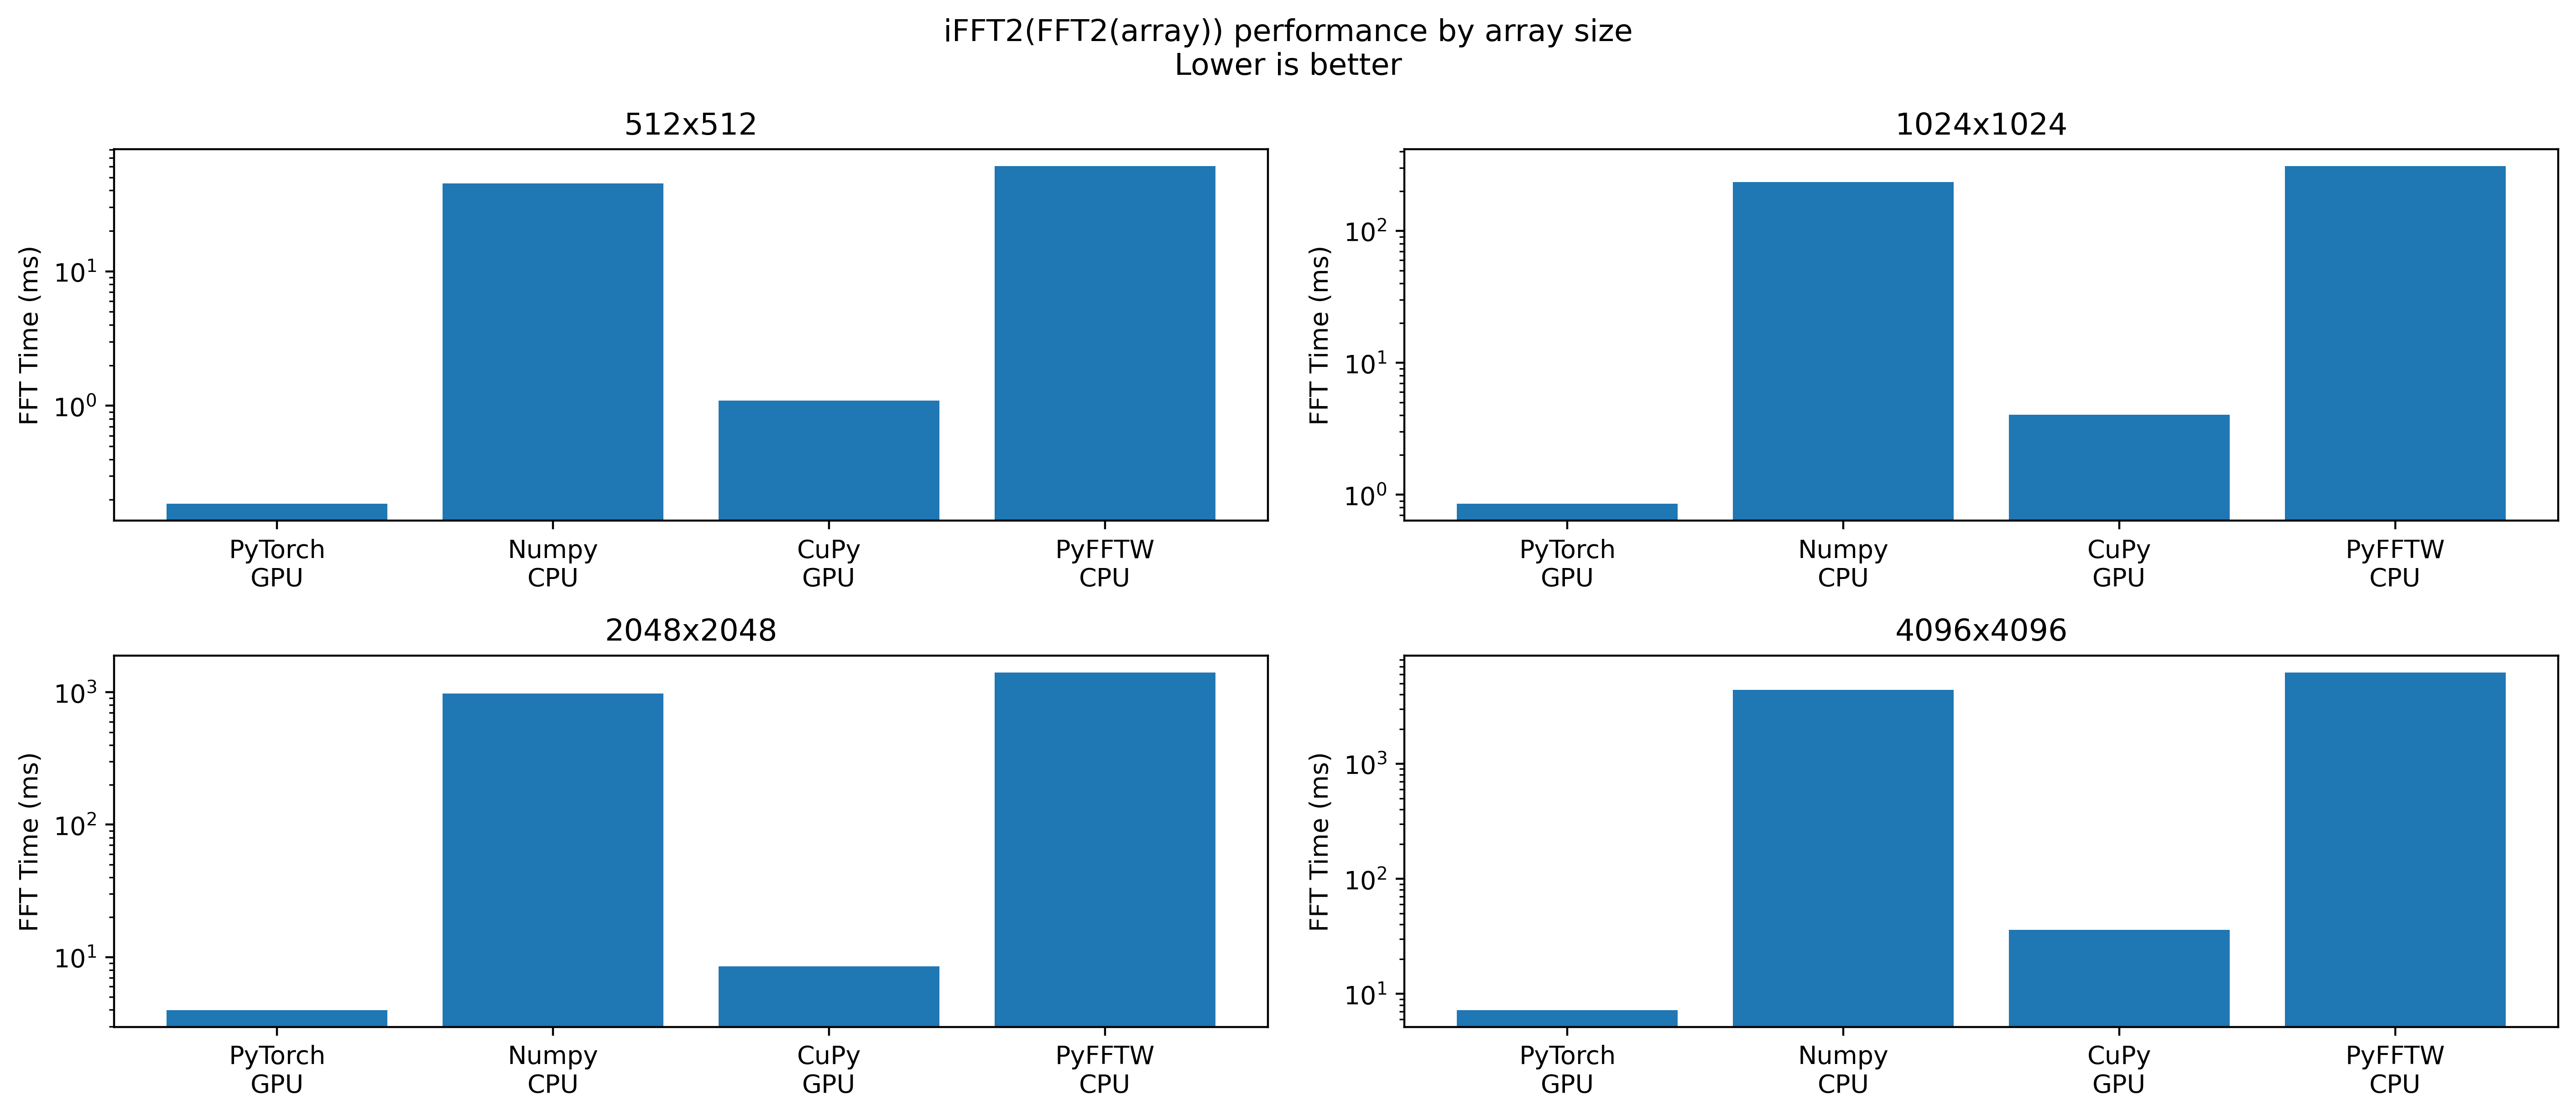

In [12]:
fig, AX = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(14,6), dpi=400)
# fig.canvas.layout.width = "1400px"
# fig.canvas.layout.height = "600px"
plt.suptitle('iFFT2(FFT2(array)) performance by array size\nLower is better')

for i in range(len(sizes)):
    t = np.array([time[i].average for time in totaltimes]) * 1000 # now in ms
    err = np.array([time[i].stdev for time in totaltimes]) * 1000
    ax = AX.flatten()[i]
    ax.set_title("{}x{}".format(sizes[i], sizes[i]))
    ax.bar(names, t)
    ax.set_yscale('log')
    ax.set_ylabel('FFT Time (ms)')
plt.savefig('FFT_Speed_by_size.png')

Average times (in ms) for a 4k x 4k array

In [13]:
times_4k = np.array([time[-1].average for time in totaltimes]) * 1000
for i in range(len(names)):
    print(" ".join(names[i].split('\n')))
    print(round(times_4k[i], 2))
    
pytorch_time_4k = times_4k[3] 
    
print()
print('4k x 4k iFFT2(FFT2())')
print('PyTorch faster than others by a factor of ')
times_4k = np.array([time[-1].average for time in totaltimes]) * 1000
for i in range(len(names)):
    print(" ".join(names[i].split('\n')))
    print(round(times_4k[i]/pytorch_time_4k, 6))

PyTorch GPU
7.23
Numpy CPU
4394.75
CuPy GPU
35.96
PyFFTW CPU
6208.65

4k x 4k iFFT2(FFT2())
PyTorch faster than others by a factor of 
PyTorch GPU
0.001164
Numpy CPU
0.707843
CuPy GPU
0.005793
PyFFTW CPU
1.0


Plot as function of software

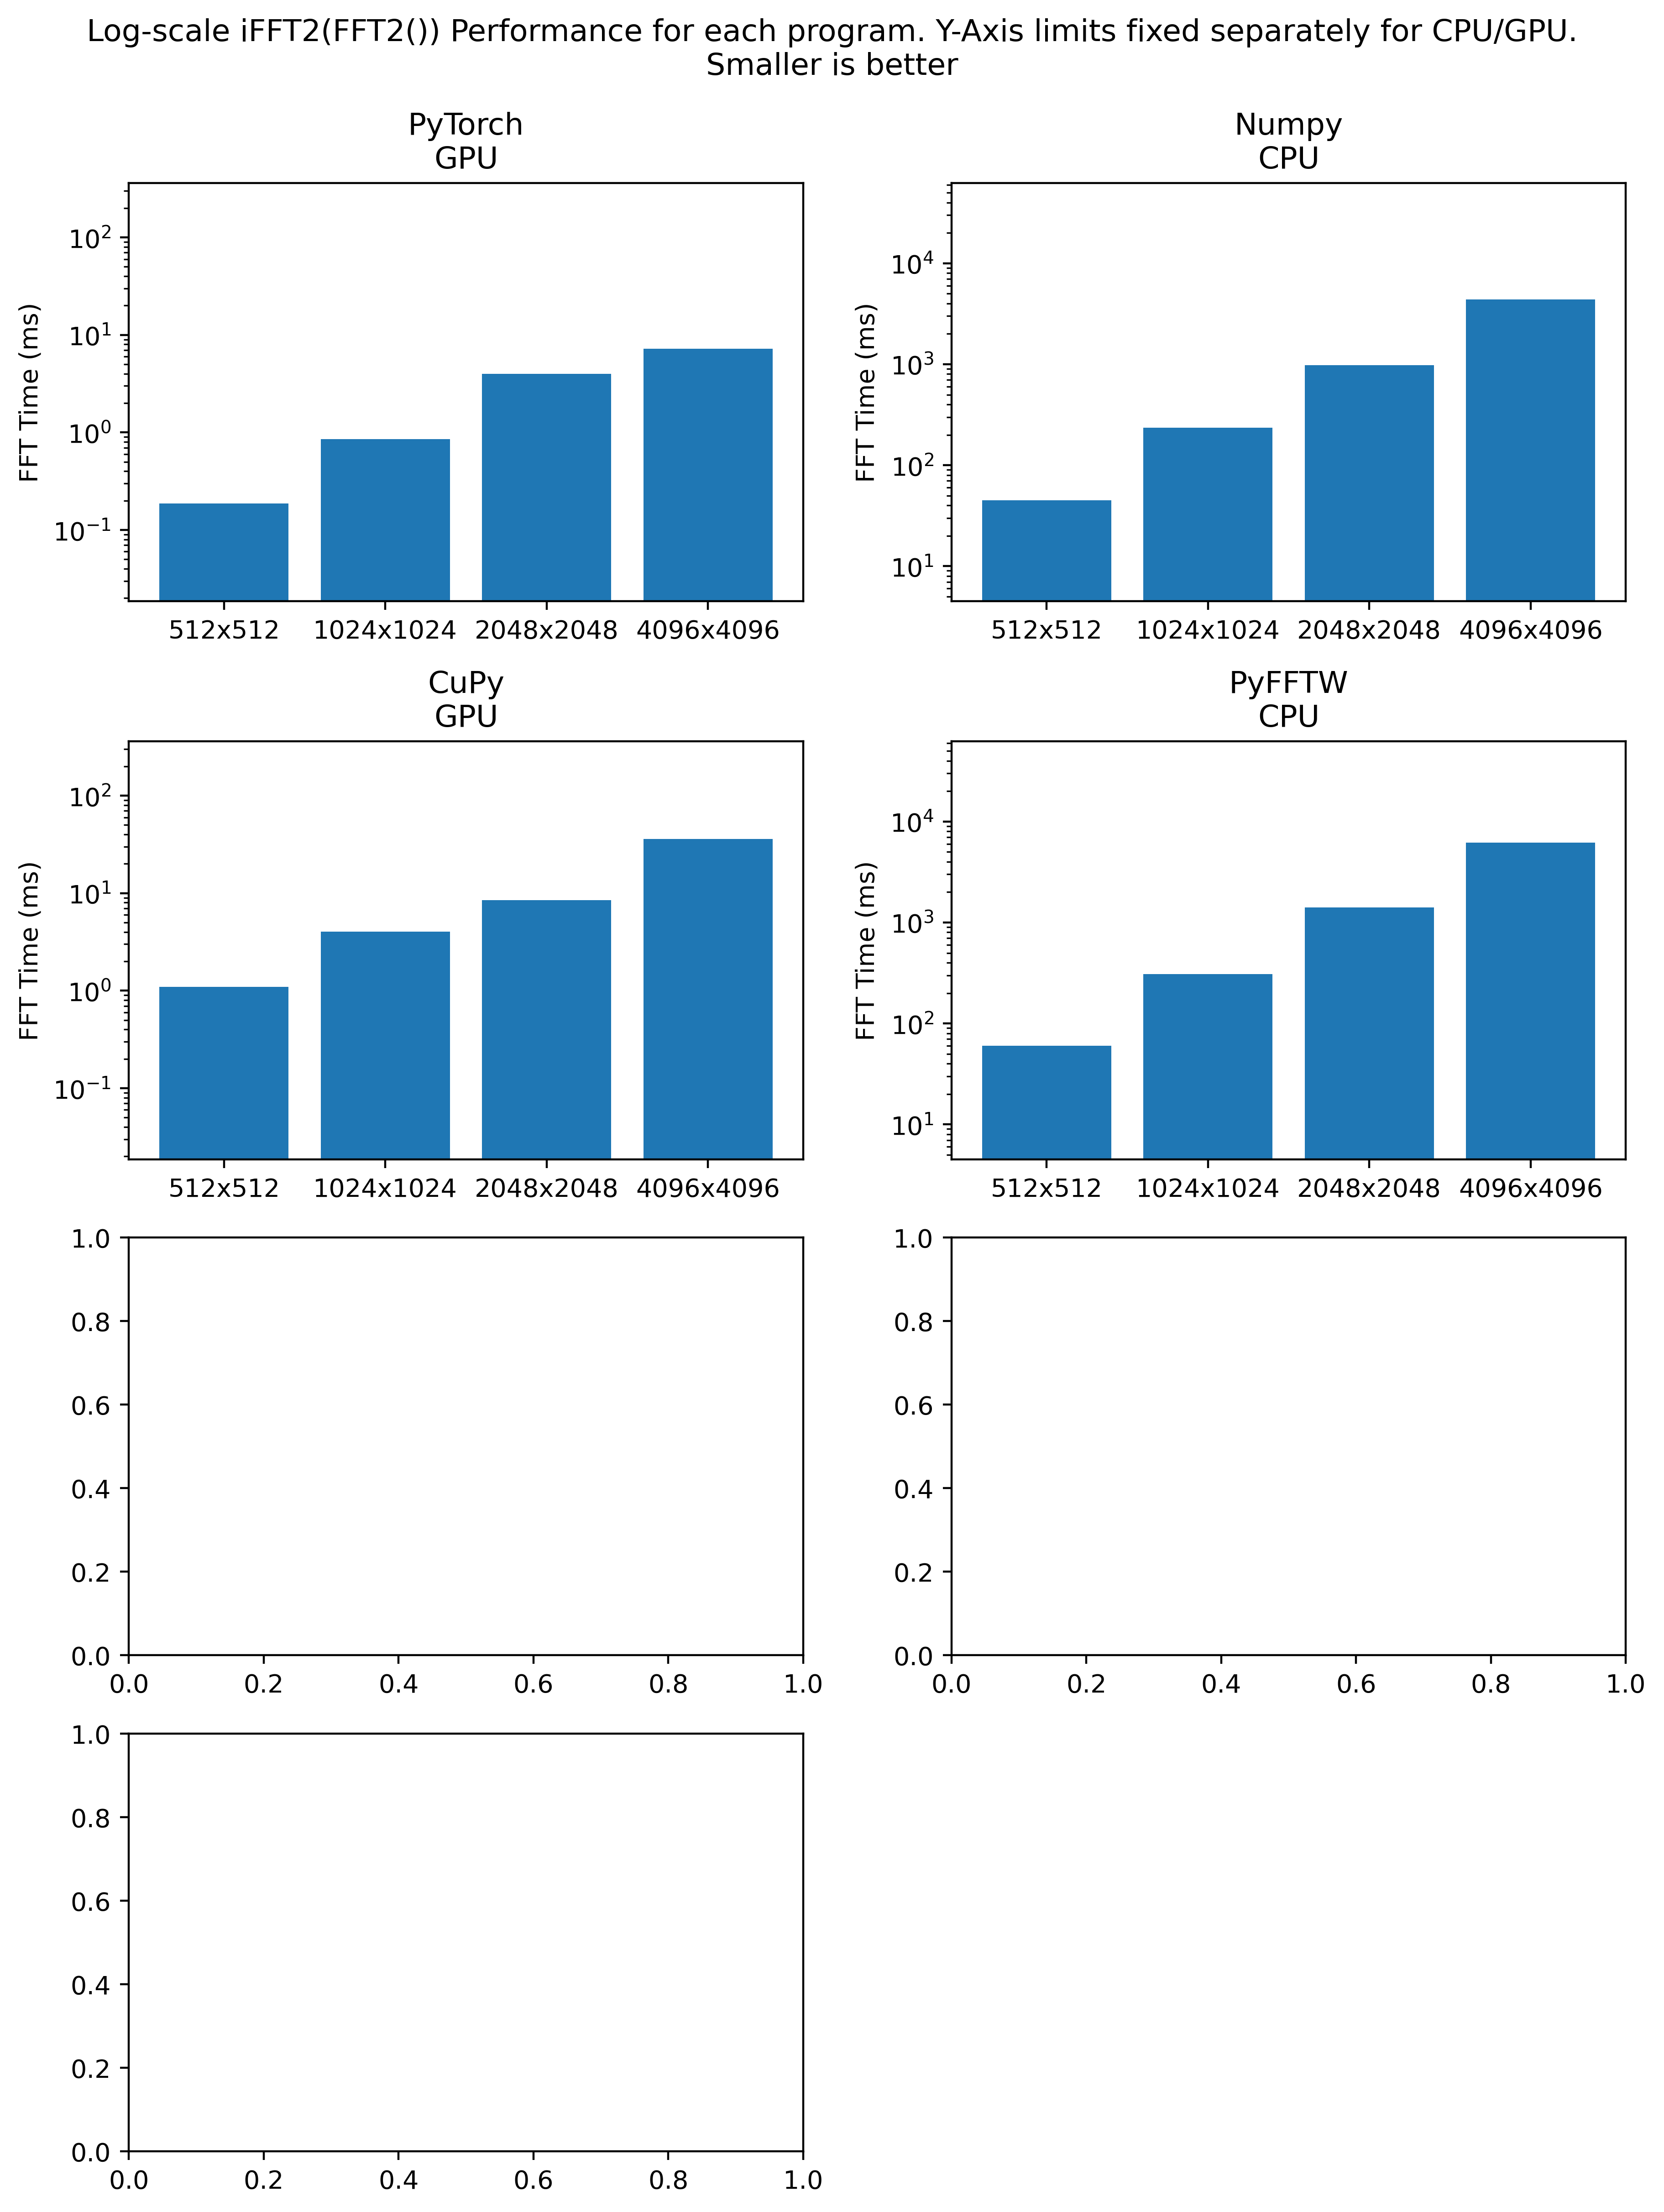

In [14]:
import matplotlib.pyplot as plt
# Log scale
fig, AX = plt.subplots(ncols=2, nrows=4, constrained_layout=True, figsize=(9,12), dpi=400)
# fig.canvas.layout.width = "1300px"
# fig.canvas.layout.height = "1000px"
cputimes = [1000 * time.average for times in totaltimes[::2] for time in times]
gputimes = [1000 * time.average for times in totaltimes[1::2] for time in times]

gmx, gmn = max(gputimes), min(gputimes)
cmx, cmn = max(cputimes), min(cputimes)
plt.suptitle('Log-scale iFFT2(FFT2()) Performance for each program. Y-Axis limits fixed separately for CPU/GPU.\nSmaller is better')

for i in range(len(names)):
    t = np.array([time.average for time in totaltimes[i]]) * 1000 # now in ms
    ax = AX.flatten()[i]
    ax.set_title(names[i])
    sizes_title = ["{}x{}".format(size, size) for size in sizes]
    ax.bar(sizes_title, t)
    ax.set_yscale('log')
    if i % 2:
        ax.set_ylim(gmn/10, gmx*10)
    else:
        ax.set_ylim(cmn/10, cmx*10)
    ax.set_ylabel('FFT Time (ms)')
AX.flatten()[-1].remove()